<a href="https://colab.research.google.com/github/passaH2O/c-HAND/blob/main/c_hand_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install dependencies and download c-HAND function if running in Colab

In [1]:
%%capture

from pathlib import Path

inColab = 'google.colab' in str(get_ipython())
if inColab:
    # install libraries
    !pip install contextily geopandas matplotlib-scalebar rasterio scikit-image
    # download c-HAND script if not present
    if not Path("c_hand.py").is_file():
        !curl -sO https://raw.githubusercontent.com/passaH2O/c-HAND/main/c_hand.py

### Import libraries

In [2]:
# import libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio

from rasterio.features import geometry_mask

# import c-HAND and raster plotting functions
from c_hand import c_hand, plot_raster

### Download example data if necessary
Resulting directory structure and file sizes:
```
data
├── aoi_coastline.geojson [5.7M]
└── houston_example_DEM_30m.tif [121M]


In [3]:
# download example data if not present
if not Path("data").is_dir():
    !curl -sL https://utexas.box.com/shared/static/sx0n3rncb191nuwokqjpmu14yo38pw61.tgz | tar xzvf -

### Read in DEM

In [4]:
# 30m DEM of houston to use as example
with rio.open(Path("data", "houston_example_DEM_30m.tif")) as ds:
    dem = ds.read(1)
    dem_profile = ds.profile
    dem[dem == dem_profile["nodata"]] = np.nan

### Show DEM with ocean pixel location

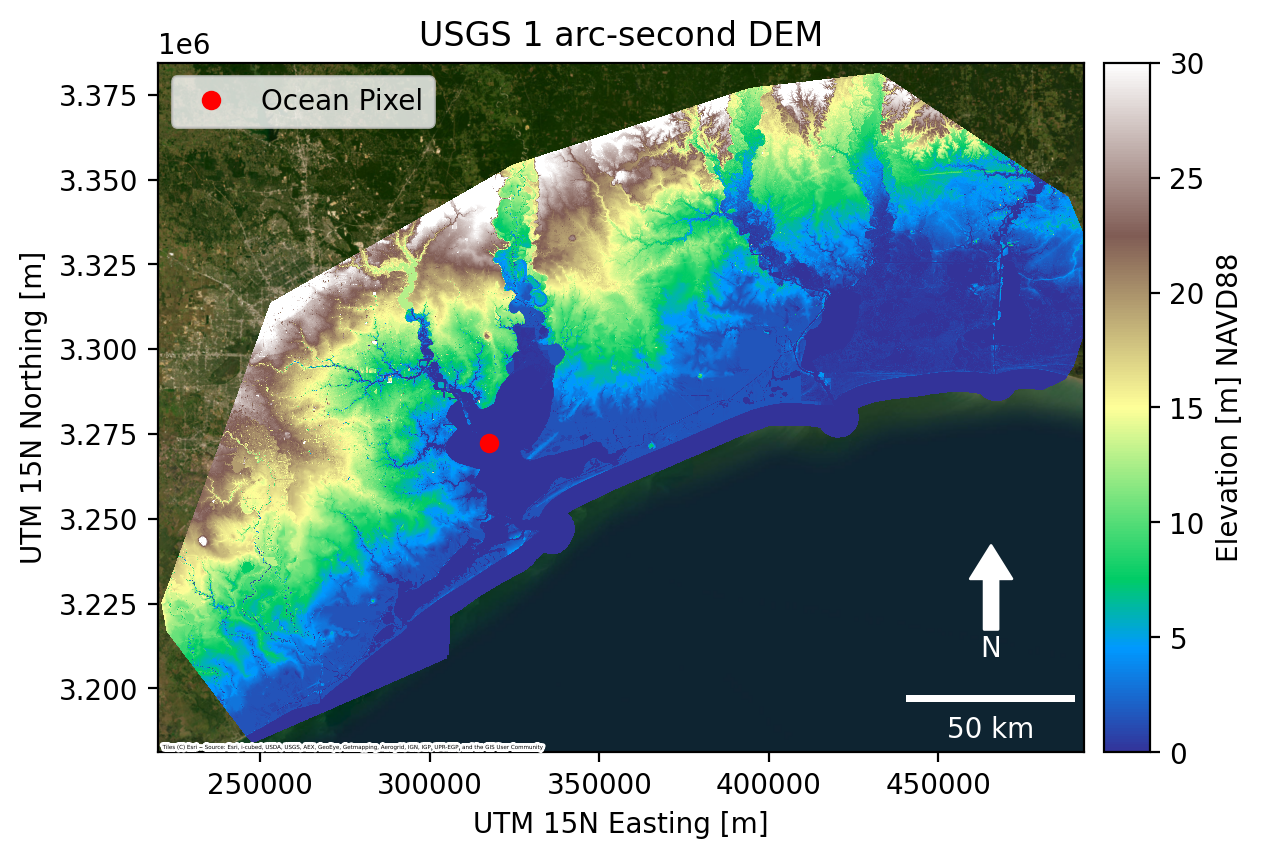

In [5]:
# UTM 15N Easting, Northing of a grid cell in the ocean
ocean_E, ocean_N = 317540, 3272260

fig, ax = plot_raster(
    raster=dem,
    profile=dem_profile,
    label="Elevation [m] NAVD88",
    interpolation="nearest",
    vmax=30,
    vmin=0,
    cmap="terrain",
)

ax.plot(ocean_E, ocean_N, "ro", label="Ocean Pixel")

# add labels
ax.legend(loc="upper left")
ax.set(
    title="USGS 1 arc-second DEM",
    xlabel="UTM 15N Easting [m]",
    ylabel="UTM 15N Northing [m]",
)

plt.show()

### run c-HAND

In [6]:
# get row, col of ocean pixel with DEM's inverse transform
ocean_row, ocean_col = rio.transform.rowcol(dem_profile["transform"], ocean_E, ocean_N)
ocean_pixel = (ocean_row, ocean_col)
ike_gage = 3.8 # meters NAVD88
inun_ike = c_hand(dem, ike_gage, ocean_pixel)

### Crop out coastline

In [7]:
# read geojson or shapefile of domain with coastline
aoi_coast = gpd.read_file(Path("data", "aoi_coastline.geojson"))
aoi_coast_mask = geometry_mask(
    aoi_coast.geometry,
    inun_ike.shape,
    dem_profile["transform"],
)

# crop array
inun_ike[aoi_coast_mask == True] = np.nan
inun_ike[inun_ike == 0] = np.nan

### Show coastal inundation map

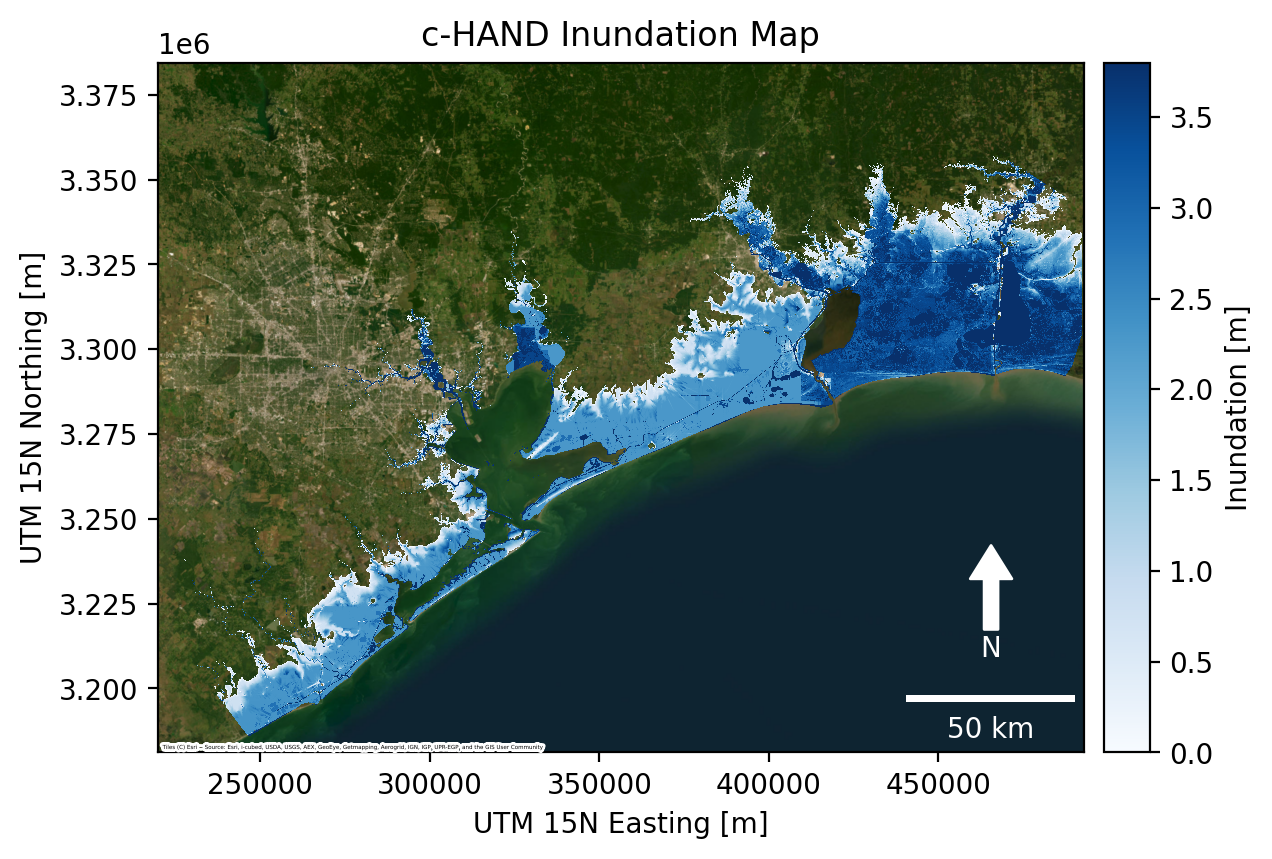

In [8]:
fig, ax = plot_raster(
    raster=inun_ike,
    profile=dem_profile,
    label="Inundation [m]",
    interpolation="nearest",
    cmap="Blues",
    vmax=ike_gage,
    vmin=0,
)

# add labels
ax.set(
    title="c-HAND Inundation Map",
    xlabel="UTM 15N Easting [m]",
    ylabel="UTM 15N Northing [m]",
)

plt.show()

# save figure
fig.savefig(Path("data", "inun_ike.png"), dpi=300, bbox_inches="tight")

### Write inundation array to GeoTIFF for viewing in GIS software

In [9]:
# write to raster, including mask if applicable
with rio.Env(GDAL_TIFF_INTERNAL_MASK=True):
    with rio.open(Path("data", "inun_ike.tif"), "w", **dem_profile) as ds_out:
        ds_out.write(inun_ike, 1)
        if isinstance(inun_ike, np.ma.MaskedArray):
            msk = (~inun_ike.mask * 255).astype("uint8")
            ds_out.write_mask(msk)